In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/omkargaikwad0405/eece5645-project/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omkargaikwad0405
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/omkargaikwad0405/eece5645-project


100%|██████████| 12.7G/12.7G [10:48<00:00, 21.0MB/s]


In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

from pyspark import SparkContext, SparkConf
from PIL import Image
import numpy as np
import random
import os

# Spark Configuration
conf = SparkConf().setAppName("Parallel-ISIC").set("spark.driver.memory", "8g")
sc = SparkContext(conf=conf)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,446 kB]
Fetched 3,703 kB in 3s (1,162 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
50 packages can be upgraded. Run 'apt list --up

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:

train_csv = "/content/eece5645-project/ISIC_2019_Training_GroundTruth.csv"
image_folder = "/content/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
# Load CSV into RDD
train_rdd = sc.textFile(train_csv).map(lambda line: line.split(","))
header = train_rdd.first()
train_rdd = train_rdd.filter(lambda row: row != header)

In [ ]:
# Transformation Functions
def preprocess_image(image_path, labels, augment=False):
    try:
        # Open image
        image = Image.open(image_path).convert('RGB')

        # Resize
        image = image.resize((224, 224))

        # Data Augmentation (if training)
        if augment:
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            angle = random.uniform(-10, 10)
            image = image.rotate(angle)

        # Convert to NumPy array and normalize
        image_array = np.array(image) / 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_array = (image_array - mean) / std

        # Change to channels-first (PyTorch format)
        image_array = np.transpose(image_array, (2, 0, 1))

        # Convert labels to float
        labels = [float(label) for label in labels]

        return image_array, labels
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [ ]:
def preprocess_partition(partition, train_dir, augment=False):
    processed_data = []
    for row in partition:
        image_id, *labels = row
        image_path = os.path.join(train_dir, f"{image_id}.jpg")
        processed_data.append(preprocess_image(image_path, labels, augment=augment))
    return iter(processed_data)

In [ ]:
import time
start_time = time.time()# Preprocess Data in Parallel
train_preprocessed_rdd = train_rdd.mapPartitions(lambda partition: preprocess_partition(partition, image_folder, augment=True))
print(train_preprocessed_rdd.count())
end_time = time.time()
print(f"Time taken: {end_time - start_time:2f} seconds")
train_data_rdd, test_data_rdd = train_preprocessed_rdd.randomSplit([0.8, 0.2], seed=42)


25331
Time taken: 321.263980 seconds


In [ ]:
# Create batches
def batch_partition(partition, batch_size):
    partition = list(partition)
    for i in range(0, len(partition), batch_size):
        yield partition[i:i+batch_size]

batch_size = 32
train_batched_rdd = train_data_rdd.mapPartitions(lambda partition: batch_partition(partition, batch_size))
test_batched_rdd = test_data_rdd.mapPartitions(lambda partition: batch_partition(partition, batch_size))

[(array([[[-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393],
          [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393],
          [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393],
          ...,
          [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393],
          [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393],
          [-2.11790393, -2.11790393, -2.11790393, ..., -2.11790393,
           -2.11790393, -2.11790393]],
  
         [[-2.03571429, -2.03571429, -2.03571429, ..., -2.03571429,
           -2.03571429, -2.03571429],
          [-2.03571429, -2.03571429, -2.03571429, ..., -2.03571429,
           -2.03571429, -2.03571429],
          [-2.03571429, -2.03571429, -2.03571429, ..., -2.03571429,
           -2.03571429, -2.03571429],
          ...,
          [-

In [ ]:
import tensorflow as tf
import time

# Define Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # Assuming 8 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training Loop
def train_on_partition(partition):
    partition = list(partition)
    if not partition:
        return []

    X_train, y_train = zip(*partition)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=5, verbose=1)
    return model.get_weights()

start_time = time.time()
model_weights = train_batched_rdd.mapPartitions(train_on_partition).collect()
end_time = time.time()

print(f"Training Time: {end_time - start_time:.2f} seconds")


25331

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_model(model, test_batched_rdd):
    test_data = test_batched_rdd.collect()
    X_test, y_test = zip(*[item for batch in test_data for item in batch])
    X_test = np.array(X_test)
    y_test = np.array([np.argmax(label) for label in y_test])

    # Predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{classification}")

evaluate_model(model, test_batched_rdd)

defaultdict(int,
            {1: 12875,
             0: 4522,
             4: 2624,
             5: 239,
             7: 628,
             2: 3323,
             6: 253,
             3: 867})

In [ ]:
classes

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

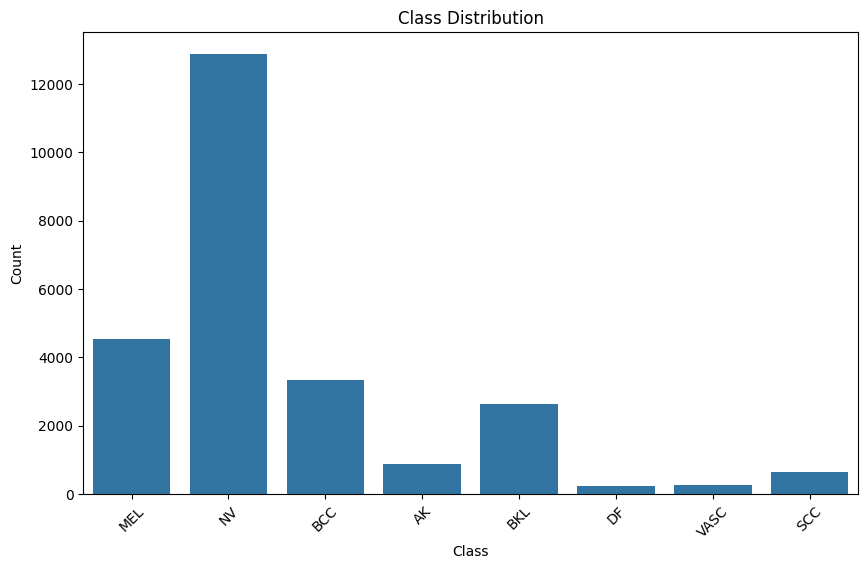

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=[class_counts[i] for i in range(len(classes))])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Split data in PySpark
train_data_rdd, test_data_rdd = rdd.randomSplit([0.8, 0.2], seed=42)

# Convert back to separate RDDs if needed
train_images = train_data_rdd.map(lambda x: x[0]).repartition(100).collect()
train_labels = train_data_rdd.map(lambda x: x[1]).repartition(100).collect()
test_images = test_data_rdd.map(lambda x: x[0]).repartition(100).collect()
test_labels = test_data_rdd.map(lambda x: x[1]).repartition(100).collect()

In [ ]:
# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])  # Resize without 'nearest' mode
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

In [ ]:
import tensorflow as tf

In [ ]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Define learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8
EPOCHS = 15

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
# Update the EfficientNetB3 model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=(300, 300, 3), pooling='avg')
base_output = base_model.output
classifier = tf.keras.layers.Dense(len(classes), activation='softmax')(base_output)
model = tf.keras.Model(inputs=base_model.input, outputs=classifier)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
import time
start_time = time.time()
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_callback],
)
end_time = time.time()
print(f"Time taken: {end_time - start_time:2f} seconds")


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 411s 427ms/step - accuracy: 0.4644 - loss: 1.5984 - val_accuracy: 0.5335 - val_loss: 1.3753 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 182s 283ms/step - accuracy: 0.6703 - loss: 0.9446 - val_accuracy: 0.7227 - val_loss: 0.7887 - learning_rate: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.0000000000000004e-05.
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 182s 284ms/step - accuracy: 0.7347 - loss: 0.7520 - val_accuracy: 0.7547 - val_loss: 0.6790 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4e-05.
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 182s 283ms/step - accuracy: 0.7832 - loss: 0.6078 - val_accuracy: 0.7758 - val_loss: 0.6119 - learning_rate: 4.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 5e-05.
Epoch 5/15
634/634 ━━━━

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 300, 300, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 32,212,889 (122.88 MB)

 Trainable params: 10,708,528 (40.85 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 21,417,058 (81.70 MB)

In [ ]:
# Evaluate model performance
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

159/159 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8453486075449338
Precision: 0.7661295920406846
Recall: 0.7479239902296273
Confusion Matrix:
 [[ 706  162   15    3   28    4    2    3]
 [ 107 2362   31    1   37    3    2    3]
 [  22   14  596   17    8    3    1   14]
 [   9    6   20   97   14    1    0   14]
 [  46   83   13   13  369    3    1   18]
 [   1    6    6    1    1   31    1    1]
 [   1    3    4    0    1    1   35    0]
 [   3    5   16    6    3    2    0   84]]


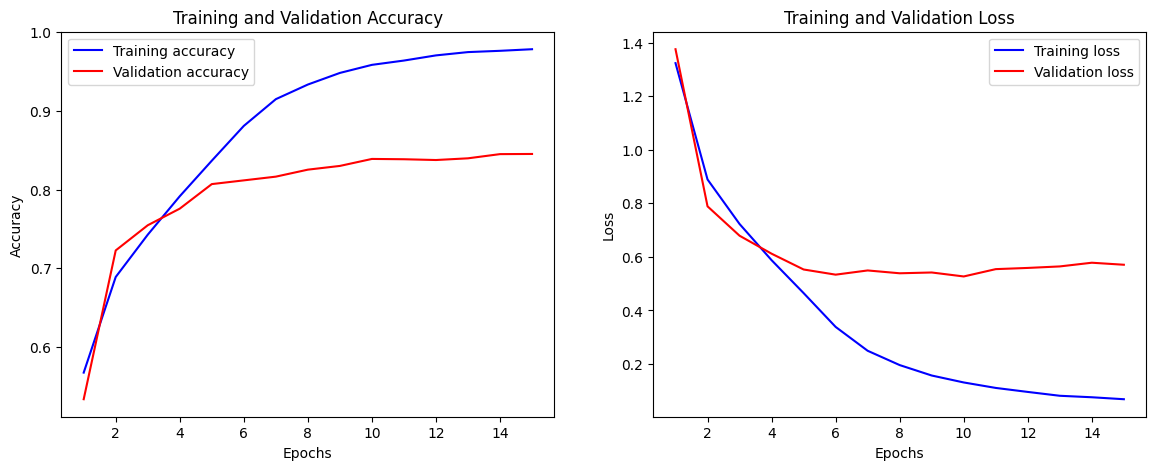

In [ ]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

# # Evaluate model performance
# y_true = np.argmax(test_labels, axis=1)
# y_pred = np.argmax(model.predict(test_ds), axis=1)

# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='macro')
# recall = recall_score(y_true, y_pred, average='macro')
# conf_matrix = confusion_matrix(y_true, y_pred)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("Confusion Matrix:\n", conf_matrix)

# # Plot confusion matrix
# def plot_confusion_matrix(y_true, y_pred, classes):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()

# plot_confusion_matrix(y_true, y_pred, classes)

# # Print the number of images belonging to each label in training data
# print("Training Class Distribution:")
# print(data.drop(columns=['image', 'UNK']).sum())

# # Print the number of images belonging to each label in test data
# print("Test Class Distribution:")
# test_data = pd.DataFrame({'image': test_images, 'label': test_labels})
# print(test_data['label'].value_counts())

# # Class index to name mapping
# class_index_to_name = {idx: cls for cls, idx in class_to_idx.items()}
# print("Class Index to Name Mapping:")
# print(class_index_to_name)